In [1]:
RANDOM_SEED = 43

In [2]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

import os
import random
import shutil

import wandb
from train import Trainer
import paths

z:\venvs\ai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [3]:
celeba_image_size = (80,64)
danbooru_image_size = (64,64)
batch_size = 64

In [4]:
celeba_image_transforms = transforms.Compose(
    [transforms.Resize(celeba_image_size), transforms.ToTensor()]
)

danbooru_image_transforms = transforms.Compose(
    [transforms.Resize(danbooru_image_size), transforms.ToTensor()]
)

A feladat megoldását 2 külön adathalmazzal is szeretnénk megtenni:
* első és fontosabb a danbooru dataset, amely celebek arcait tartalmazza előfeldolgozottan (cropped, aligned)
* második a danbooru dataset, amely anime karakterek arcait tartalmazza
* (opcionálisan egy kevert adathalmazt is szeretnénk tesztelni, hogy milyen eredményeket tudunk kapni)

Az adathalmazokat előre letöltöttük és kicsomagoltuk a tömörített fájlokat, majd így egy volume segítségével kerülnek a containerhez felcsatolásra

Mivel képgenerálásról beszélünk, a tesztelési fázis nem teljesen jelent egyértelmű feladatot
Ennek ellenére felkészülünk training, validation és test dataloaderekkel is, melyeknek bemenete a random 8:1:1 arányban felosztott adathalmaz. Kimenetük pedig egy batch_size-onként "adagolt" adathalmaz a modellünknek, image_size formájú 3 csatornás (RGB) Tensorokként

In [5]:
celeba_generator = torch.Generator().manual_seed(RANDOM_SEED)
danbooru_generator = torch.Generator().manual_seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [6]:
def move_random_files(source_dir, dest_dir, num_or_percentage):
    # Get the list of files in the source directory
    files = os.listdir(source_dir)

    if isinstance(num_or_percentage, float) and 0 <= num_or_percentage <= 1:
        num_files_to_move = int(len(files) * num_or_percentage)
    else:
        num_files_to_move = int(num_or_percentage)

    # Randomly select files to move
    files_to_move = random.sample(files, num_files_to_move)

    # Move selected files to the destination directory
    for file in files_to_move:
        source_path = os.path.join(source_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(source_path, dest_path)
        print(f"Moved {file} to {dest_dir}")

In [ ]:
source_directory = os.path.join(paths.celeba["data"], "0")
destination_directory = paths.celeba["test"]

move_random_files(source_directory, destination_directory, 512)

In [ ]:
source_directory = os.path.join(paths.danbooru["data"], "0")
destination_directory = paths.danbooru["test"]

move_random_files(source_directory, destination_directory, 512)

In [7]:
celeba_data = ImageFolder(root=paths.celeba["data"], transform=celeba_image_transforms)
celeba_train_data, celeba_val_data = random_split(
    celeba_data, [0.8, 0.2], generator=celeba_generator
)

celeba_train_dataloader = DataLoader(
    celeba_train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)
celeba_val_dataloader = DataLoader(
    celeba_val_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

In [8]:
danbooru_data = ImageFolder(root=paths.danbooru["data"], transform=danbooru_image_transforms)
danbooru_train_data, danbooru_val_data = random_split(
    danbooru_data, [0.8, 0.2], generator=danbooru_generator
)

danbooru_train_dataloader = DataLoader(
    danbooru_train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)
danbooru_val_dataloader = DataLoader(
    danbooru_val_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

# Model

In [9]:
# wandb.login()

In [10]:
# wandb.init(project="dl-hf_celeba")
celeba_trainer = Trainer(parallel=False)
celeba_trainer.add_paths(paths.celeba)
celeba_trainer.add_dataloaders(
    celeba_train_dataloader, celeba_val_dataloader
)

In [11]:
# wandb.init(project="dl-hf_danbooru")
danbooru_trainer = Trainer(parallel=False)
danbooru_trainer.add_paths(paths.danbooru)
danbooru_trainer.add_dataloaders(
    danbooru_train_dataloader, danbooru_val_dataloader
)

# Training

In [ ]:
celeba_trainer.train()

In [ ]:
danbooru_trainer.train()

# Evaluation

KeyboardInterrupt: 

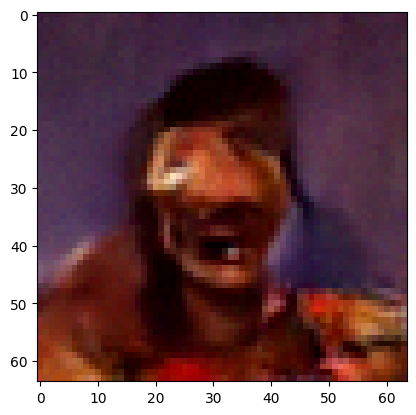

In [12]:
# TODO: DODO
celeba_trainer.add_model(os.path.join(paths.celeba["models"], "sample_30.pth"))
celeba_trainer.sample_without_figs(n_samples=512, batching=True)

In [ ]:
celeba_trainer.test_FID(
    paths.celeba["samples"], paths.celeba["test"], batch_size=16
)

In [ ]:
# TODO: DODO
danbooru_trainer.add_model(os.path.join(paths.danbooru["models"], "sample_30.pth"))
danbooru_trainer.sample_without_figs(n_samples = 512, batching=True)

In [ ]:
danbooru_trainer.test_FID(
    paths.danbooru["samples"], paths.danbooru["test"], batch_size=16
)